# Edelstein Klassifikation

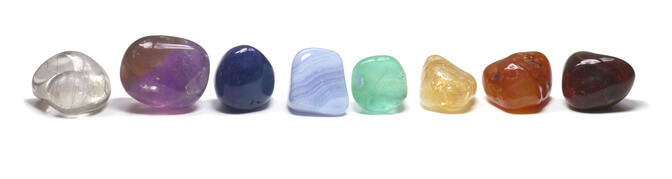

## Projekt im Rahmen des Advanced Data Science Moduls FS 2021

### Kevin Schenk, Peter Felder, Manuel Huggenberger

#### Im Rahmen dieses Projektes möchten wir anhand eines selbst zusammengestellten Datensatzes ein Modell trainieren, dass Bilder von geschliffenen Edelsteinen klassifiziert. Das Projekt beinhaltet das Sammeln der Daten, das Aufbereiten der Daten und das anschliessende Erstellen eines Modells zur Klassifikation.

#### Geschliffene Edelsteine unterscheiden sich je nach Schliff nur durch ihre Farbe, das macht es dem ungeschulten Augen schwer, diese zu unterscheiden. Uns hat sich deshalb die Frage gestellt, ob eine Erkennung mittels Machine Learning umsetzbar ist. Der Beantwortung dieser Frage nehmen wir uns in diesem Projekt an. Als Ziel haben wir uns eine Genauigkeit von über 50% gesetzt.

#### Für die Ausarbeitung des Projektes verwenden wir aus dem Modul Gelerntes sowie Recherchiertes aus dem Internet.

#### In einem ersten Schritt gilt es einen neuen Datensatz zu erstellen. Da wir an spezifischen Bilder interessiert sind, mussten wir zuerst passende Internetseiten finden. Wir benötigen Seiten, welche Bilder einzelner geschliffener Edelsteine inklusive deren Bezeichnung darstellen. Wir haben uns für folgende drei Seiten entschieden:
#### [www.minerals.net](https://www.minerals.net)
#### [www.rasavgems.com](https://www.rasavgems.com)
#### [www.gempundit.com](https://www.gempundit.com)
#### Während es sich bei der ersten Seite um eine Enzyklopädie handelt, sind die letzten beiden Seiten jeweils Edelsteinhändler.

#### Damit wir mit dem Sammeln von Daten beginnen können, richten wir uns eine Ordnerstruktur ein und importieren die Web-Scraping Library BeautifulSoup sowie den WebDriver von Selenium.


### Importierung der benötigten Libraries

In [1]:
from bs4 import BeautifulSoup as bs
from bs4 import SoupStrainer
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
import requests
import os
import time

### Setup der globalen Einstellungen

In [2]:
#Für die spätere Verwendung definieren wir wichtige Parameter
SAVE_LOCATION = 'Dataset'
path = os.getcwd()
spath = path
driver = webdriver.Chrome('chromedriver')

### Erstellen des Ordners für den Datensatz (wenn noch nicht vorhanden)

In [3]:
if not os.path.exists(SAVE_LOCATION):
    os.mkdir(SAVE_LOCATION)

## 1. Datensammlung

#### Kommen wir nun zum Webscraping der ausgewählten Internetseiten. Vorbereitend haben wir die jeweiligen Pages genauer untersucht und festgestellt, dass die einen statische und die anderen dynamische Webseiten sind.

#### Bei der Seite https://www.minerals.net/GemStoneMain.aspx handelt es sich um eine statische Webseite. Das heisst, dass bei jedem Aufruf der gleiche Inhalt gezeigt wird. Statische Webseiten sind einfacher zu scrapen.

#### Bei dynamischen Websites ist das Grundgerüst der Seiten immer das selbe. Nur der Inhalt wird aus einer Datenbank dynamisch geladen und dargestellt. Dies ist bei den Seiten https://www.rasavgems.com und https://www.gempundit.com/gemstones der Fall. Für das Scrapen jener Seiten kommt ein zusätzlich WebDriver zum Einsatz. Ausserdem wurde bei letzterer Webseite ein Cookie Consent Tool eingesetzt, der beim Aufrufen der Seite das Akzeptieren der Cookies automatisiert.

#### Wir beginnen den Aufbau des Datensatzes mit der Seite [www.minerals.net](https://www.minerals.net/).
#### Hierfür parsen wir die Edelstein-Übersichtsseite und extrahieren anschliessend sämtliche weiterleitende Hyperlinks und die Namen der präsentierten Edelsteine.
#### Durch Inspektion der Seite haben wir den relevanten Teil eruiert und schränken diesen mittels SoupStrainer ein, um direkt mit den relevanten Informationen weiterzuarbeiten.

In [ ]:
#Wir parsen die GemStoneMain Page
url = 'https://www.minerals.net/GemStoneMain.aspx'
html = requests.get(url).text
gemstones = SoupStrainer('table', {'id':'ctl00_ContentPlaceHolder1_DataList1'})
soup = bs(html,'html.parser',parse_only=gemstones)

In [ ]:
#Alle Hyperlinks des Parses werden in der links list gespeichert
links = []
for href in soup.findAll('a'):
    if 'href' in href.attrs:
        links.append(href.attrs['href'])

In [ ]:
#Für die Namensgebung der Edelsteine speichern wir die Bezeichnung der Hyperlinks in der folder list
folder = []
for href in soup.findAll('a'):
    if 'href' in href.attrs:
        folder.append(href.text)

#### Aufgrund der Formatierung der Seite müssen wir auf Duplikate und leere Einträge in unsere Liste aufpassen.
#### Ebenfalls sollen alle Apostrophe gelöscht werden.

In [ ]:
links = list(dict.fromkeys(links))
folder = [x.replace('\'', '') for x in folder if x != '\'']
folder = list(filter(None,folder))

#### Damit wir im nächsten Schritt die Bilder herunterladen können, bereiten wir im bereits erstellten Ordner Dataset die Ordner-Struktur vor.
#### Für jede Edelsteinart wird ein eigener Ordner erstellt und anhand der gescrapten Namen benannt.

In [ ]:
path = spath + '\Dataset'
os.chdir(path)

In [ ]:
for gem in folder:
    if not os.path.exists(gem):
        os.mkdir(gem)

### Herunterladen der Bilder

#### Mittels Analyse des oberen Soup grenzen wir erneut unsere Suche ein und erstellen aus diesen Daten eine Liste aller Bilder URLs.
#### In einem zweiten Schritt laden wir diese herunter und benennen diese nach gewünschtem Schema.
#### Während des Downloads achten wir jeweils darauf, die Bilder im korrekten Subordner abzuspeichern.

In [ ]:
counter = 1

for link, gem in zip(links,folder):
    site = 'https://www.minerals.net/' + link
    driver.get(site)
    #Einschränkung der Suche auf die relevante Tabelle mit Bildern
    images = SoupStrainer('table', {'id':'ctl00_ContentPlaceHolder1_DataList1'})
    soup = bs(driver.page_source,'html.parser',parse_only=images)
    img_tags = soup.findAll('img')
    #Einfügen der Hyperlinks jedes gefundenen Bildes in die urls list
    urls = ['https://www.minerals.net/' + img['src'] for img in img_tags]
    
    #Hier stellen wir sicher, dass die Edelsteinbilder auch im korrekten Ordner abgespeichert werden
    path = os.getcwd() + '\\' + gem
    os.chdir(path)
    
    #Schreiben der Bilder mit gewünschter Namesgebung
    for url in urls:
        filename = gem + '_' + str(counter)+ '.jpeg'
        counter += 1
        with open(filename, 'wb') as f:
            response = requests.get(url, stream=True)
            f.write(response.content)
            
    
    os.chdir('..')
    counter = 1
    
path = spath
os.chdir(path)

### Vorgehen für Rasavgems
#### Das Vorgehen für die Seite [www.rasavgems.com](https://www.rasavgems.com) ist weitestgehend analog der https://www.minerals.net/. Jedoch muss hier zusätzlich ein WebDriver eingesetzt werden.

#### Webdriver werden für die Interaktion mit Browsern und die Weitergabe von Anweisungen für Automatisierungsskripte an die Browser verwendet. Sie sorgen dafür, dass keine interne Logik der Browser-Funktionalitäten verloren geht. Jeder Browser hat seinen eigenen WebDriver.
#### Ein weiterer Punkt, weshalb ein WebDriver bei dynamischen Seiten notwenig ist, ist deren längere Ladezeit. Während auf statischen Seiten der Inhalt schnell genug geladen ist, kann es auf dynamischen Seiten zu fehlerhaftem Scraping führen, wenn der Inhalt noch nicht komplett geladen ist. Hier kann entweder über eine Verzögerung oder ein Check sichergestellt werden, dass alles fertig geladen ist.

In [ ]:
url = 'https://www.rasavgems.com/Choose-gemstone.html'
html = requests.get(url).text
gemstones = SoupStrainer('table', {'id':'ContentPlaceHolder1_Itemlist'})
soup = bs(html,'html.parser',parse_only=gemstones)

In [ ]:
#Füllen der links und folder lists durch neuen Parse
links = []
for href in soup.findAll('a'):
    if 'href' in href.attrs:
        links.append(href.attrs['href'])

links = list(dict.fromkeys(links))
        
folder = []
for href in soup.findAll('a'):
    if 'href' in href.attrs:
        folder.append(href.text)
        
folder = [x.replace('\n', '') for x in folder if x != '\n']
folder = list(filter(None,folder))

In [ ]:
#Es soll überprüft werden ob für alle Edelsteine bereits ein Order besteht, wenn nicht soll dieser erstellt werden
path = spath + '\Dataset'
os.chdir(path)

for gem in folder:
    if not os.path.exists(gem):
        os.mkdir(gem)

In [ ]:
#Finden und speichern der relevanten Bilder
counter = 1

for link, gem in zip(links,folder):
    site = 'https://www.rasavgems.com/' + link
    driver.get(site)
    #In diesem Punkt stellen wir sicher, dass sämtliche Inhalte der dynamischen Webseite fertig geladen sind
    wait = WebDriverWait(driver,15)
    try:
        element = wait.until(
        EC.presence_of_element_located((By.ID, "Product_List")))
        imgs_form = driver.find_element_by_id('Product_List')
    finally:
        html_gems = driver.page_source
    soup = bs(html_gems,'lxml')
    images = soup.find_all('div', {'class','product-one'})
    
    path = os.getcwd() + '\\' + gem
    os.chdir(path)
    
    for data in images:
        for link in data.find_all('img'):
            url = link.get('src').replace('../','')
            filename = gem + '_0' + str(counter)+ '.jpeg'
            counter += 1
            with open(filename, 'wb') as f:
                response = requests.get('https://www.rasavgems.com/' + url)
                f.write(response.content)

    
    os.chdir('..')
    counter = 1
    
path = spath
os.chdir(path)

### Vorgehen für Gempundit

#### Es handelt sich auch hierbei um eine dynamische Seite. Zum Scrapen jener, wird hier im Speziellen zusätzlich ein User Agent eingesetzt.
#### Dieser ist notwendig, da die Webseite den Standard User Agent blockiert hat. Ohne diese Maskierung könnten wir keine Daten scrapen.
#### Der User Agent erstellt einen String, der vom Client über die Header einer Anfrage gesendet wird. Damit erkennt der Server die Anfrage und kann diese anschliessend in der richtigen Form beantworten.
#### Durch den String wird dem Server mitgeteilt, mit welchem Browser und Betriebssystem auf die Webseite zugegriffen wird. Damit wird das Gerät erkannt und die Kommunikation ermöglicht.

In [25]:
headers = {"Host":"20min.ch",
"Accept":"text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8",
"Accept-Encoding":"gzip,deflate,br",
"Cookie": "cookieconsent=true",
          }

url = 'https://www.gempundit.com/gemstones'
driver.get(url)
time.sleep(5)
soup = bs(driver.page_source,'lxml')
images = soup.find_all('ul', {'class','stonesCategoryProduct'})

In [29]:
#Füllen der links und folder lists durch neuen Parse
links = []
for data in images:
    for link in data.find_all('a'):
        url = link.get('href')
        links.append(url)

folder = []
for data in images:
    for link in data.find_all('img'):
        title = link.get('title')
        folder.append(title)
folder = [x.replace('/', '') for x in folder if x != '/']

In [55]:
#Es soll überprüft werden, ob für alle Edelsteine bereits ein Order besteht, wenn nicht soll dieser erstellt werden
path = spath + '\Dataset'
os.chdir(path)

for gem in folder:
    if not os.path.exists(gem):
        os.mkdir(gem)

In [56]:
#Finden und speichern der relevanten Bilder
counter = 1

#Parameter zur Filterung unerwünschter Bilder
shand = "hand"
scertified = "certified"
sCertified = "Certified"


for link, gem in zip(links,folder):
    site = link
    driver.get(site)
    soup = bs(driver.page_source,'lxml')
    images = soup.find_all('div', {'class','category-products custom-products'})
    
    path = os.getcwd() + '\\' + gem
    os.chdir(path)
    
    for data in images:
        for link in data.find_all('img'):
            url = link.get('data-src')
            #Unter Anwendung der Filterparamenter schreiben wir die Bilder auf die Festplatte
            if url != None and shand not in url and scertified not in url and sCertified not in url: 
                filename = gem + '_00' + str(counter)+ '.jpeg'
                counter += 1
                with open(filename, 'wb') as f:
                    response = requests.get(url)
                    f.write(response.content)

    
    os.chdir('..')
    counter = 1
    
path = spath
os.chdir(path)

In [3]:
#Am Ende des Webscrapings kann der WebDriver geschlossen werden
driver.quit()

### Manuelle Kontrolle

#### An diesem Punkt haben wir unsere gesammelten Daten manuell überprüft. Wir fanden diverse leere Ordner, animierte Bilder (GIF), unerwünschte Bilder und doppelte Ordner.
#### Leere Ordner wurden erstellt, wenn auf einer Seite zwar diese Rubrik von Edelsteinen angeboten wurde, aber effektiv keine verkauft wurden. Diese Ordner haben wir gelöscht.
#### Ebenso haben wir alle GIFs aus dem Datensatz entfernt. Als unerwünschte Bilder haben wir Bilder mit mehreren Edelsteinen in einem Bild definiert, diese wurden ebenfalls gelöscht.
#### Zuletzt sind uns noch Ordner aufgefallen, welche doppelt waren (z.B. Cat's Eye und Cats Eye). Da wir die Bilder aus beiden Ordner möchten, wurden diese zusammengeführt.


### Umbenennen der Dateien

#### Damit der Datensatz übersichtlicher ist und wir bei der weiteren Bearbeitung alles nachvollziehen können, benennen wir alle Dateien im Datensatz nach dem Schema Edelsteinname_Nummer um.

In [6]:
dpath = spath + '\Dataset'

In [69]:
dataset = os.scandir(dpath)

for entry in dataset:
    #nur Ordner sollen aufgelistet werden
    if(entry.is_dir()):
        #dpath mit dem Ordnernamen ergänzen
        f_path= os.path.join(dpath, entry.name)
        #Dateien sollen klein geschrieben sein
        lowercasename = entry.name.lower()
        files = os.listdir(f_path)
        
        iterator = 0
        for name in files:
            file, file_extension = os.path.splitext(name)
            dst = "{}_{}{}".format(lowercasename, iterator, file_extension.lower())
            
            if len(files) != 0:
                os.rename(os.path.join(f_path,name), os.path.join(f_path,dst)) 
            iterator += 1        

### Split Folders

#### Die splitfolders Library erlaubt es uns den Datensatz in ein Trainings- und Testset aufzuteilen. Wir teilen in 80% Trainings- und 20% Testset auf. Der Seed macht den Split reproduzierbar.

In [4]:
import matplotlib.pyplot as plt
from random import randint
import numpy as np
import splitfolders
import cv2
import os

In [71]:
splitfolders.ratio("Dataset", output="dataset_final", seed=1337, ratio=(.8,.2))

Copying files: 8323 files [00:13, 605.53 files/s]


### Check Data

#### Um den gesplitteten Datensatz zu analysieren, visualisieren wir diesen in einem Balkendiagramm. Wie unten ersichtlich, besteht der Datensatz aus 8328 Bildern und 88 unterschiedlichen Edelsteinarten.

In [5]:
names, counter = [], []

#Datensatz durchlaufen und files in Array schreiben
for root, dirs, files in os.walk('dataset_final'):
    name = os.path.basename(root)
    
    if len(files) > 0:
        counter.append(len(files))
        if name not in names:
            names.append(name)

88 Edelsteinsorten mit insgesamt 8328 Bildern


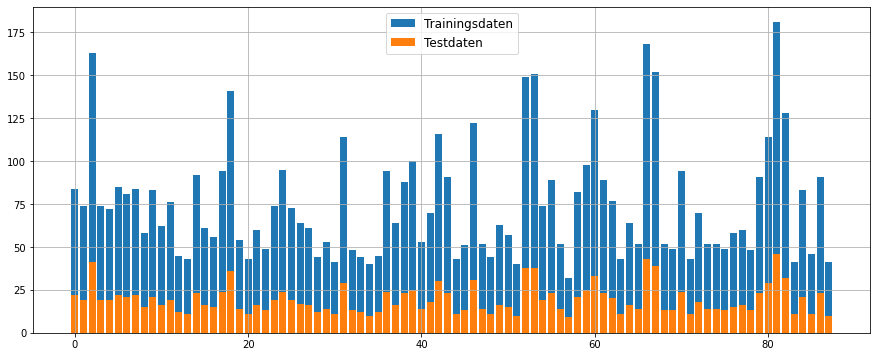

In [4]:
count = len(names)
print('{} Edelsteinsorten mit insgesamt {} Bildern'.format(len(names), sum(counter)))

f, ax = plt.subplots(figsize=(15,6))
if(counter[0])<47:
    plt.bar(range(count), counter[count:], label = 'Trainingsdaten')
    plt.bar(range(count), counter[0:count], label = 'Testdaten')
else:
    plt.bar(range(count), counter[0:count], label = 'Trainingsdaten')
    plt.bar(range(count), counter[count:], label = 'Testdaten')
ax.grid()
ax.legend(fontsize = 12);

## 2. Datenaufbereitung

#### Aufgrund des von uns gewählten Ansatzes müssen die Trainingsdaten noch aufbereitet werden. Einerseits möchten wir die Bilder so zuschneiden, dass möglichst wenig Hintergrund auf dem Bild ersichtlich ist und andererseits müssen wir sicherstellen, dass die Bilder im RGB Farbraum sind.

#### Für das Zuschneiden der Bilder bedienen wir uns der Canny Funktion aus der cv2 Library, welche wir unten genauer beschreiben. Wir haben im Internet und durch eigenes Ausprobieren festgestellt, dass die Zuschneidung besser funktioniert, wenn wir die Bilder zuerst etwas vergrössern. Wir vergrössern die Bilder um 150%.

#### Die cv2 Library besitzt ebenfalls eine Color Convert Funktion, welche sicherstellt, dass alle Bilder im RGB Farbraum sind.

In [6]:
#Erstellung der benötigten Arrays
images, labels = [], []

#Variabeln für Bildbreite / Bildhöhe definieren
img_w, img_h = 220, 220

#Trainingsdaten Verzeichnis durchlaufen und Daten in Array speichern
for root, dirs, files in os.walk('dataset_final/train/'):
    tmp = os.path.basename(root)
    for file in files:
        labels.append(tmp)
        try:
            #Bilder auslesen
            image = cv2.imread(root+'/'+file)
            #Anpassung Bildgrösse
            image = cv2.resize(image,(int(img_w*1.5), int(img_h*1.5)))
            #Farbraum anpassen
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            images.append(image)
        except Exception as e:
            print(e,file)
            
images = np.array(images)

#### Die Labels mit den Edelsteinnamen werden als Nummer abgespeichert, um eine einfachere Iteration zu ermöglichen.

In [7]:
for i, n in enumerate(labels):
    for j, k in enumerate(names):
        if n == k:
            labels[i] = j
labels = np.array(labels)

### Anzeigen von Bildern vor Zuschnitt

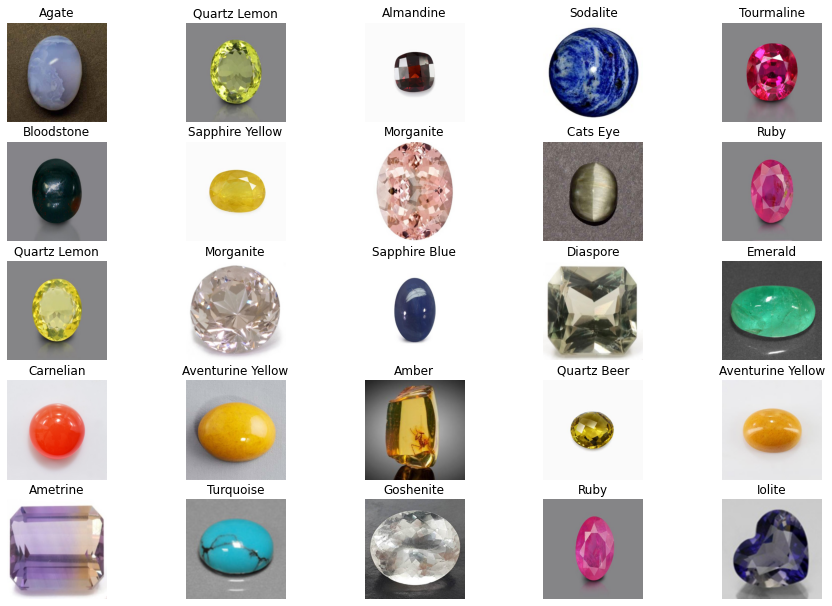

In [228]:
f,ax = plt.subplots(5,5) 
f.subplots_adjust(0,0,2,2)
for i in range(0,5):
    for j in range(0,5):
        rnd = randint(0,len(images))
        cl = labels[rnd]
        ax[i,j].imshow(images[rnd])
        ax[i,j].set_title(names[cl])
        ax[i,j].axis('off')

### Beschreibung der Canny Funktionalität

#### Im nächsten Schritt wenden wir wie erwähnt die Canny Funktion der cv2 Library an. Diese erkennt Kanten in einem Bild und ermöglicht so das Zuschneiden der Bilder. Untenstehend haben wir das Vorgehen kommentiert und visualisiert.

In [2]:
img = images[randint(0,len(images))]
crop = img.copy()
edges = cv2.Canny(img, img_w, img_h)

#Wir checken ob das Bild komplett Schwarz ist oder nicht. Wenn mehr als 11 "Pixel"/Nonzero-Einträge in der Matrix gefunden sind => Kante wurde erkannt
if(np.count_nonzero(edges)>11):
    pts = np.argwhere(edges>0)
    y1,x1 = pts.min(axis=0)
    y2,x2 = pts.max(axis=0)

    end = img[y1:y2, x1:x2]  

    edge_size = 1        
    
    #Zur Veranschaulichung heben wir den Zuschneidrahmen in Rot hervor
    crop[y1-edge_size:y1+edge_size, x1:x2] = [255, 0, 0]
    crop[y2-edge_size:y2+edge_size, x1:x2] = [255, 0, 0]
    crop[y1:y2, x1-edge_size:x1+edge_size] = [255, 0, 0]
    crop[y1:y2, x2-edge_size:x2+edge_size] = [255, 0, 0]

    #Anpassung des zugeschnittenen Bildes an die Standardgrösse
    end = cv2.resize(end,(img_w, img_h))

else:
    #Bei Bilder wo keine Kante erkannt wurde, wird lediglich die Grösse angepasst
    end = cv2.resize(img,(img_w, img_h))

#Ausgabe der Bilder
fig, ax = plt.subplots(1,4,figsize=(10, 10))
ax[0].imshow(img)
ax[0].set_title('Original', fontsize=14)
ax[1].imshow(edges, cmap='gray')
ax[1].set_title('Kantenerkennung', fontsize=14)
ax[2].imshow(crop)
ax[2].set_title('Zuschneidrahmen', fontsize=14)       
ax[3].imshow(end)
ax[3].set_title('Endprodukt', fontsize=14)  

plt.show()

NameError: name 'images' is not defined

### Bilder zuschneiden
#### Die Bilder werden anhand der obigen Funktion zugeschnitten und in Cropages gespeichert.

In [8]:
cropages = np.ndarray(shape=(len(images), img_w, img_h, 3), dtype=int)

counter = 0
for img in images: 
    try:
        edges = cv2.Canny(img, img_w, img_h)            
        #Wenn edges (11 oder mehr nonzeros) gefunden wurden, crop image anhand min/max
        if(np.count_nonzero(edges)>11):           
            points = np.argwhere(edges>0)
            ymin,xmin = points.min(axis=0)
            ymax,xmax = points.max(axis=0)
            
            #Bild cropen und anschliessend auf Standardgrösse anpassen
            new_img = img[ymin:ymax, xmin:xmax]
            new_img = cv2.resize(new_img,(img_w, img_h))
        
        #Wenn keine edges gefunden wurden, Bild direkt an Standardgrösse anpassen
        else:
            new_img = cv2.resize(img,(img_w, img_h))
    
    #Im Falle eines Fehlers, Bild direkt an Standardgrösse anpassen und Fehler ausgeben (war für debugging wichtig)
    except Exception as e:
        print(e)
        new_img = cv2.resize(img,(img_w, img_h))
    
    #cropages array mit neuen Bildern befüllen
    cropages[counter] = new_img
    counter += 1

### Anzeigen von Bildern nach Zuschnitt

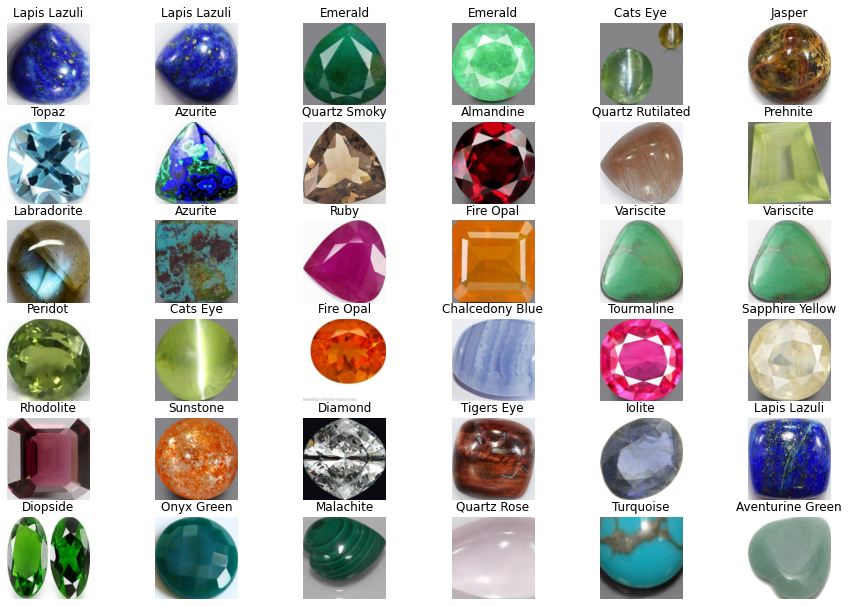

In [322]:
f,ax = plt.subplots(5,5) 
f.subplots_adjust(0,0,2,2)
for i in range(0,5):
    for j in range(0,5):
        rnd = randint(0,len(cropages))
        cl = labels[rnd]
        ax[i,j].imshow(cropages[rnd])
        ax[i,j].set_title(names[cl])
        ax[i,j].axis('off')

## 3. Modellerstellung
### Split into train and validation Set
#### Als Erstes müssen unseren Trainingsdatensatz weiter aufteilen. Dies passiert mittels train_test_split von der sklearn Library. Anschliessend importieren wir die benötigen ML Libraries.

In [9]:
from sklearn.model_selection import train_test_split
#Definition Testdaten und Validierungsdaten
X_train, X_val, y_train, y_val = train_test_split(cropages, labels, shuffle = True, test_size = 0.2, random_state = 42)

In [10]:
#Wichtig: tensorflow-gpu mittels Befehl conda install tensorflow-gpu=2.3 tensorflow=2.3=mkl_py38h1fcfbd6_0 (siehe https://github.com/ContinuumIO/anaconda-issues/issues/12194#issuecomment-751700156)
#installieren. Sonst werden nicht alle nötigen Dependencies mit installiert.
from tensorflow.python.client import device_lib
devices = device_lib.list_local_devices()
print(devices)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16284278769830698781
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 14447053613291489688
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7017170208
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5936208766414621795
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 5747109626477291898
physical_device_desc: "device: XLA_GPU device"
]


### Keras importieren

In [23]:
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import optimizers

### Hyperparamter setzen

#### Die Hyperparameter des Modells haben wir in unseren Test oft anpassen müssen, deshalb haben wir diese separat aufgeführt.

In [12]:
kernel_size = 3                              #Kernelgrösse
max_pool = 2                                 #Defintion der pool_size
epoch = 50                                   # Wie oft der ganze Datensatz von Model gesehen wird
batch_size = 32                              # Anzahl samples welche pro Batch benutzt werden
iterations = len(X_train) // batch_size      # Anzahl Iterationen pro Epoche
validations = len(X_val) // batch_size       # Anzahl Validierungen pro Epoche

### Das Modell
#### Auf Basis der Vorlesung haben wir uns für die Ausarbeitung eines Convolutional Neural Network (CNN) mit MixedPooling entschieden. 
#### Die Anzahl der Layers haben wir durch mehrmalige Durchläufe eruiert. Dabei haben wir jeweils im TensorBoard die Metriken verfolgt und uns für die beste Lösung von fünf Layern entschieden.
#### Zu Beginn haben wir getestet, ob AveragePooling einen positiven Einfluss auf unser Resulat hat. Wir stellten fest, dass es sich positiv auf das Resultat auswirkt, wenn AveragePooling in einem späteren Layer angewendet wird. Auch in der [Literatur (Kapitel 3.1)](https://pages.ucsd.edu/~ztu/publication/pami_gpooling.pdf) haben wir Hinweise auf diesen Umstand gefunden.
#### Die Batchsize der Layer nimmt jeweils proportional zur Abnahme der Dimension zu. Wenn also durch Pooling die Grösse halbiert wird, verdoppelt sich die Batchsize.
#### Die Dropoutrate von 0.5 hinzugefügt, um Overfitting zu vermeiden.

In [13]:
model = Sequential()

# erster layer
model.add(Conv2D(batch_size, (kernel_size, kernel_size), activation='relu', padding='same', input_shape=(img_w, img_h, 3)))
model.add(MaxPooling2D((max_pool, max_pool)))

# zweiter layer
model.add(Conv2D(2*batch_size, (kernel_size, kernel_size), activation='relu', padding='same'))
model.add(MaxPooling2D((max_pool, max_pool))) 

# dritter layer
model.add(Conv2D(4*batch_size, (kernel_size, kernel_size), activation='relu', padding='same'))
model.add(MaxPooling2D((max_pool, max_pool))) 

# vierter layer
model.add(Conv2D(4*batch_size, (kernel_size, kernel_size), activation='relu', padding='same'))
model.add(AveragePooling2D(pool_size= (2, 2), strides= (2, 2))) 

# fünfter layer
model.add(Conv2D(4*batch_size, (kernel_size, kernel_size), activation='relu', padding='same'))
model.add(MaxPooling2D((max_pool, max_pool))) 

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(16*batch_size, activation='relu'))
model.add(Dense(88, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 220, 220, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 110, 110, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 55, 55, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 55, 55, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 27, 27, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 27, 27, 128)       1

#### Als Optimizer haben wir Adam ausgewählt. In unseren Tests haben wir sdg, RMSprop, Adagrad und Adadelta ausprobiert. Adam lieferte uns jedoch die besten Resultate. Trotz Versuch, die Learning Rate manuell zu konfigurieren, sind wir mit der Standardimplementation von adam besser gefahren.

In [14]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

### Datenaugmentation
#### Mit Hilfe des ImageDataGenerators von keras augmentieren wir unseren Trainingsdatensatz. Gemäss Recherche ist es sinnvoll, den Validierungsdatensatz nicht zu augmentieren.

In [15]:
from keras.preprocessing.image import ImageDataGenerator

#Definition der Trainingsdatenfunktion und deren Paramenter
train_datagen = ImageDataGenerator(
        rotation_range=25,
        zoom_range=0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2,
        horizontal_flip=True
        )

#Definition der Validierungsdatenfunktion
val_datagen = ImageDataGenerator()

### Die ImageDataGenerator Funktionalität
#### Der ImageDataGenerator von keras ermöglicht es, die Grösse unseres Datensatzes künstlich zu erhöhen. Wie unten visualisiert, generiert dieser Bilder anhand unserer train_datagen Einstellungen. Bilder werden zufällig entweder gedreht, verschoben oder gezoomt.

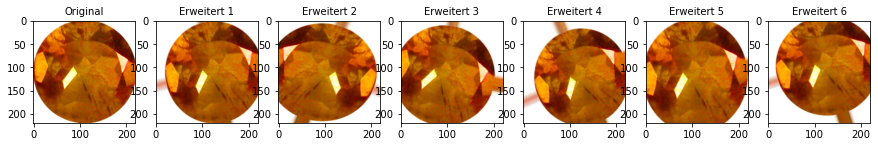

In [43]:
n = randint(0,len(X_train))
samples = np.expand_dims(X_train[n], 0)
it = train_datagen.flow(samples, batch_size=batch_size)
cols = 7

fig, ax = plt.subplots(nrows=1, ncols=cols, figsize=(15, 10))
ax[0].imshow(X_train[n], cmap='gray')
ax[0].set_title('Original', fontsize=10)

for i in range(1,cols):
    batch = it.next()
    image = batch[0].astype('uint32')
    ax[i].set_title('Erweitert {}'.format(i), fontsize=10)
    ax[i].imshow(image, cmap='gray')

In [16]:
#Erstellung der für die Modellinitialisierung notwendigen Datensets
train_gen = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_gen = val_datagen.flow(X_val, y_val, batch_size=batch_size)

### Modellinitialisierung
#### Die Initialisierung des Trainings starten wir mit den augmentierten Daten und den vorab definierten Hyperparameter.
#### Desweiteren nutzen wir zwei Callbacks. Zum einen möchten wir das Modell der Epoche mit kleinstem loss speichern, zum anderen füttern wir zur Analyse das TensorBoard. Das TensorBoard haben wir hauptsächlich zum Testen unserer Änderungen benötigt, zu Präsentationszwecken werden wir unten eine separate Darstellung des Modells erstellen.

In [17]:
#Damit wir die Logdateien nicht jedesmal überschreiben, haben wir folgenden Code übernommen.
root_logdir = os.path.join(os.curdir,"my_logs")

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()

In [17]:
cp = ModelCheckpoint("best_model.h5", monitor='loss', verbose=0, save_best_only=True, mode='auto', save_freq=1)
tensorboard = TensorBoard(run_logdir)
m = model.fit(
       train_gen,
       steps_per_epoch= iterations,
       epochs=epoch, 
       validation_data = val_gen,
       validation_steps = validations,
       callbacks=[cp,tensorboard],
       verbose = 1
       )

Epoch 1/50
165/165 [==============================] - 44s 268ms/step - loss: 3.9855 - accuracy: 0.1232 - val_loss: 2.7801 - val_accuracy: 0.2447
Epoch 2/50
165/165 [==============================] - 38s 232ms/step - loss: 2.5867 - accuracy: 0.2871 - val_loss: 2.2754 - val_accuracy: 0.3384
Epoch 3/50
165/165 [==============================] - 36s 216ms/step - loss: 2.2039 - accuracy: 0.3561 - val_loss: 1.9474 - val_accuracy: 0.4093
Epoch 4/50
165/165 [==============================] - 36s 219ms/step - loss: 1.9252 - accuracy: 0.4223 - val_loss: 1.9139 - val_accuracy: 0.4520
Epoch 5/50
165/165 [==============================] - 36s 220ms/step - loss: 1.7705 - accuracy: 0.4708 - val_loss: 1.5717 - val_accuracy: 0.5206
Epoch 6/50
165/165 [==============================] - 36s 217ms/step - loss: 1.6426 - accuracy: 0.4996 - val_loss: 1.4809 - val_accuracy: 0.5686
Epoch 7/50
165/165 [==============================] - 36s 219ms/step - loss: 1.5639 - accuracy: 0.5173 - val_loss: 1.5206 - val_ac

### Darstellung der Trainings- und Validierungsgenauigkeit

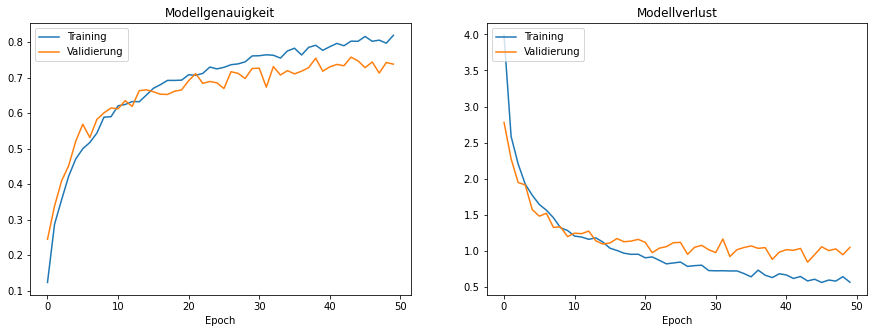

In [18]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
axs[0].plot(m.history['accuracy'])
axs[0].plot(m.history['val_accuracy'])
axs[0].set_title('Modellgenauigkeit')
axs[0].legend(['Training', 'Validierung'], loc='upper left')

axs[1].plot(m.history['loss'])
axs[1].plot(m.history['val_loss'])
axs[1].set_title('Modellverlust')
axs[1].legend(['Training', 'Validierung'], loc='upper left')

for ax in axs.flat:
    ax.set(xlabel='Epoch')

### Analyse der Ergebnisse

#### Die Modellgenauigkeit zeigt auf, dass die Validierungs- und Trainingsgenauigkeit relativ nahe zueinander sind. Da die Validierungsgenauigkeit unter der Trainingsgenauigkeit liegt, kann dies auf ein Overfitting hinweisen. Auch der Abstand zwischen Validierungs- und Trainingsverlust ist zwar relativ klein, deutet aber auf Overfitting hin.

#### Mit einer maximal erreichten Validierungsgenauigkeit von über 70% haben wir unser Ziel von mindetens 50% erreicht und können das Modell nun auf unseren Testdatensatz anwenden.

### Analyse der falsch klassifizierten Edelsteine
#### Um die Fehler unseres Modelles besser zu verstehen sehen wir uns die Confusion Matrix an. Wir lassen uns jeweils nur falsch klassifizierte Edelsteine anzeigen.

<AxesSubplot:>

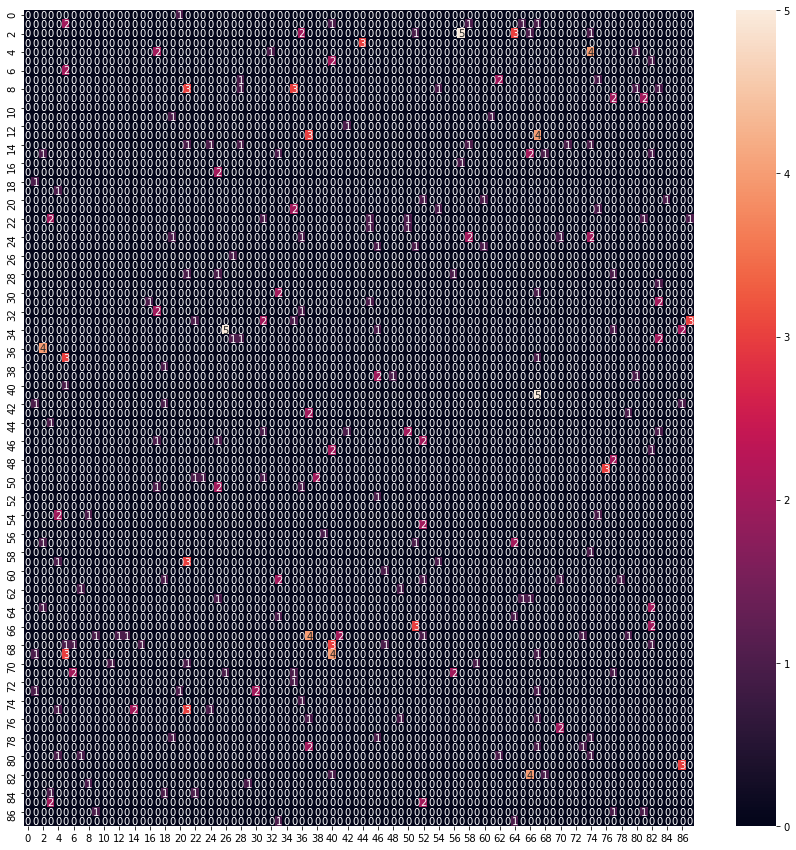

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

y_pre_test=model.predict(X_val)
#Ordnet jedem Bild einen Edelstein-Int-Wert zu (0 - 87)
y_pre_test=np.argmax(y_pre_test,axis=1)
cm=confusion_matrix(y_val,y_pre_test)

#Diagonale auf 0 setzen, um nur falsch klassifizierte darzustellen.
for i in range(len(names)):
    cm[i][i] = 0

plt.figure(figsize = (15,15))
sn.heatmap(cm, annot=True)

#### Am stärksten interessiert sind wir an den oftmals falsch erkannten Edelsteinen. Beispielsweise werden die Edelsteine mit der Nummer 2 und 57 häufig verwechselt. Dabei handelt es sich um Almandine und Pyrope, beide sehr ähnlich in der Farbe.
#### Dies lässt die Frage auftauchen, ob Machine Learning sich den gleichen Herausforderungen wie der Mensch ausgesetzt sieht? Zur genaueren Kontrolle bilden wir unten einige falsch klassifzierte Edelsteine ab.

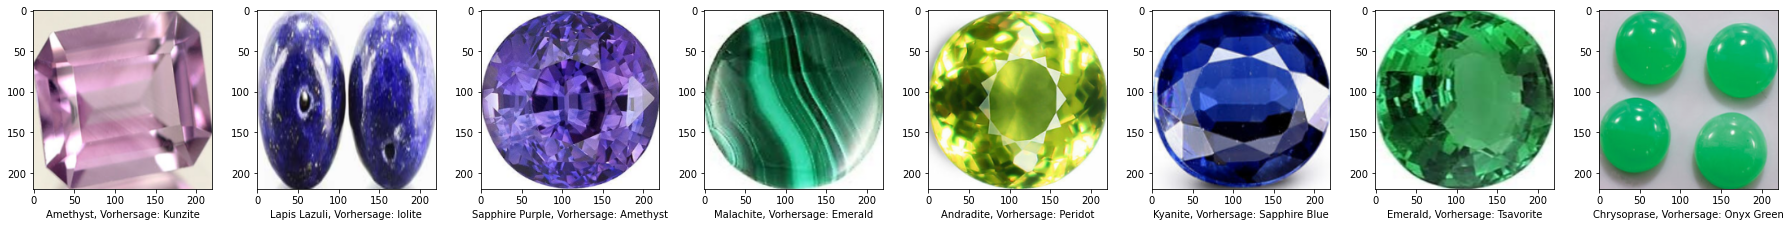

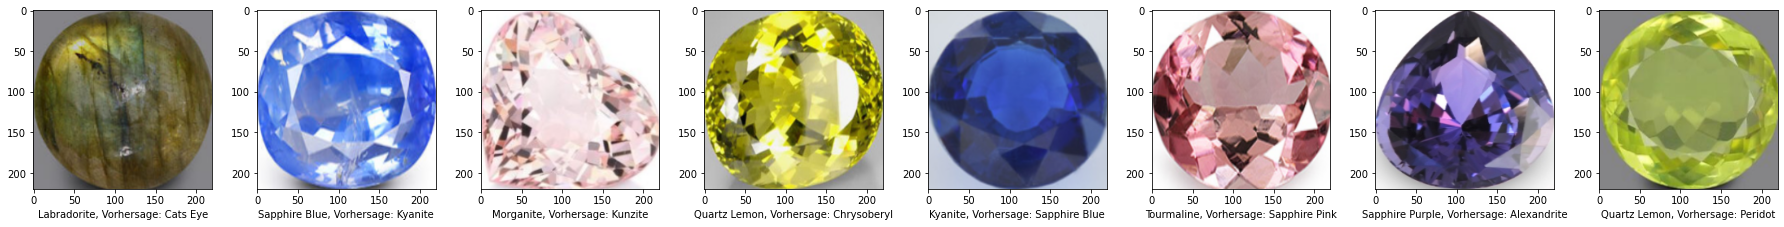

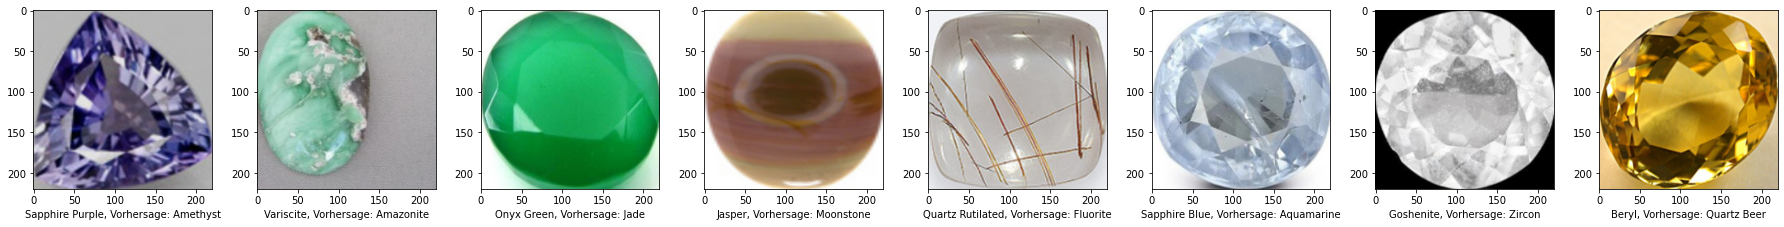

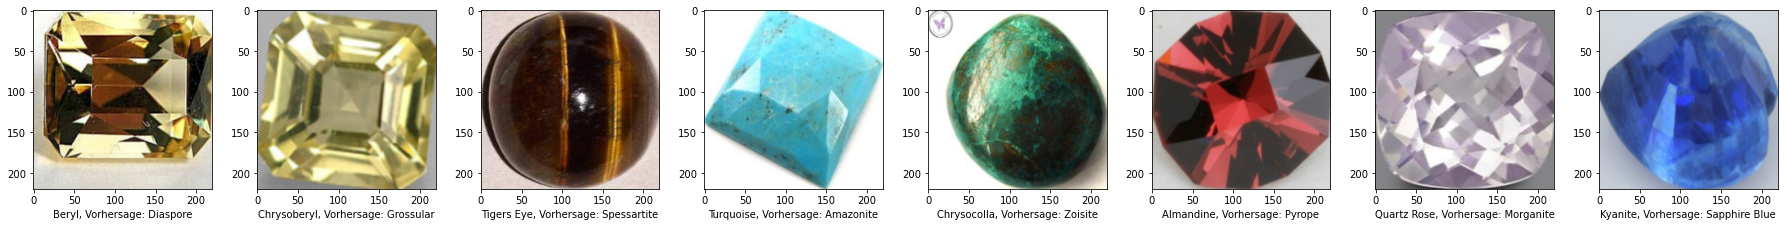

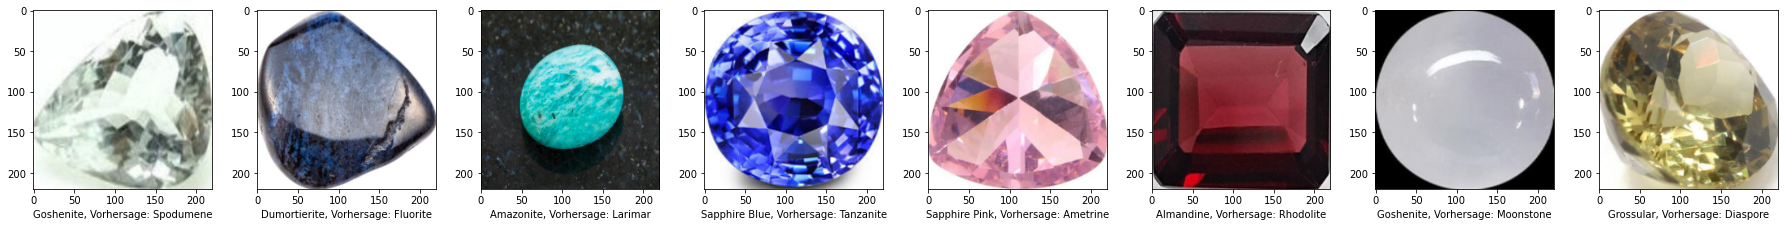

In [21]:
#Check ob korrekt vorhergesagt. Fülle Liste mit True wenn korrekt und False wenn nicht
x=(y_pre_test-y_val!=0).tolist()
#Lösche alle korrekt klassifizierten Einträge
x=[i for i,l in enumerate(x) if l!=False]

figit = 0

for i in range (5):
    fig,ax=plt.subplots(1,8,figsize=(25,25))
    fig.tight_layout()
    
    for j in range(8):
        ax[j].imshow(X_val[x[figit]])
        ax[j].set_xlabel('{}, Vorhersage: {}'.format(names[y_val[x[figit]]],names[y_pre_test[x[figit]]]))
        figit += 1
    

#### Offensichtlich hat das Modell aufgrund der Ähnlichkeit vieler Edelsteine ebenfalls Schwierigkeiten. Dies ist jedoch wenig verwunderlich. Unten haben wir zufällig gelbliche Edelsteine aus unserem Datensatz ausgewählt. Eine korrekte Zuordnung für den Laien ist auf Basis dieser Bilder nahezu unmöglich.

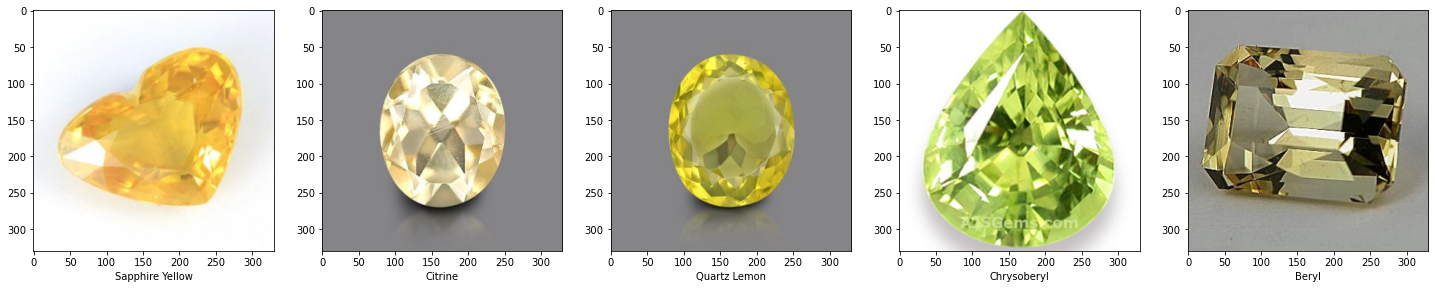

In [246]:
similar = ['Sapphire Yellow', 'Citrine', 'Quartz Lemon', 'Chrysoberyl', 'Beryl']

#Da wir die labels zu Integer umgewandelt haben, müssen wir dies für similar auch machen
rfinal = []
for i, n in enumerate(similar):
    for j, k in enumerate(names):
        if n == k:
            rfinal.append(j)
          
fig,ax=plt.subplots(1,len(similar),sharey=False,figsize=(25,25))

for i in range(len(similar)):
    #np.where gibt alle Indices zürick für welche die Condition stimmt. Wir wählen den Ersten und drucken das Bild
    ax[i].imshow(images[np.where(labels==rfinal[i])[0][1]])
    ax[i].set_xlabel(similar[i])

## 4. Test unseres Modelles
#### Während dem Trainingsverlauf haben wir bewusst das Model der Epoche mit niedrigstem Loss-Wert gespeichert. Dieses wenden wir nun auf unseren Test an.
### Vorbereiten der Testdaten für die Anwendung des trainierten Modells

In [19]:
images, labels = [], []

for root, dirs, files in os.walk('dataset_final/test/'):
    tmp = os.path.basename(root)
    for file in files:
        labels.append(tmp)
        try:
            image = cv2.imread(root+'/'+file)
            image = cv2.resize(image,(int(img_w*1.5), int(img_h*1.5)))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            images.append(image)
        except Exception as e:
            print(e,file)
            
images = np.array(images)

for i, n in enumerate(labels):
    for j, k in enumerate(names):
        if n == k:
            labels[i] = j
labels = np.array(labels)

cropages = np.ndarray(shape=(len(images), img_w, img_h, 3), dtype=int)

counter = 0
for img in images: 
    try:
        edges = cv2.Canny(img, img_w, img_h)            
        #Wenn edges (11 oder mehr nonzeros) gefunden wurden, crop image anhand min/max
        if(np.count_nonzero(edges)>11):           
            points = np.argwhere(edges>0)
            ymin,xmin = points.min(axis=0)
            ymax,xmax = points.max(axis=0)
            
            #Bild cropen und anschliessend auf Standardgrösse anpassen
            new_img = img[ymin:ymax, xmin:xmax]
            new_img = cv2.resize(new_img,(img_w, img_h))
        
        #Wenn keine edges gefunden wurden, Bild direkt an Standardgrösse anpassen
        else:
            new_img = cv2.resize(img,(img_w, img_h))
    
    #Im Falle eines Fehlers, Bild direkt an Standardgrösse anpassen
    except Exception as e:
        print(e)
        new_img = cv2.resize(img,(img_w, img_h))
    
    #cropages array mit neuen Bildern befüllen
    cropages[counter] = new_img
    counter += 1

#### Wir laden das von uns gespeicherte Modell

In [29]:
model = load_model("best_model.h5")

### Genauigkeit des Modells bei Anwendung auf Testdatensatz

#### Wir vergleichen die Anzahl der korrekt erkannten Bilder mit allen Bildern und erreichen eine Genauigkeit von 74.31%.

In [85]:
#Wir lassen die Bilder durch unser Modell vorhersagen
ytest = model.predict_classes(cropages)

#Wir zählen die positiv erkannten Bilder
p = 0
for (i,n) in zip(ytest,labels):
        if i == n:
            p += 1
            
#Berechnung der Genauigkeit und anschliessend Ausgabe            
accuracy = p / len(ytest)
print('Genauigkeit: %.2f'%(accuracy*100))

Genauigkeit: 74.31


### Visualisierung unseres Outputs
#### Für die Visualisierung wählen wir zufällig Bilder unseres Testdatensatzes aus und zeigen, ob diese korrekt klassifiziert wurden.

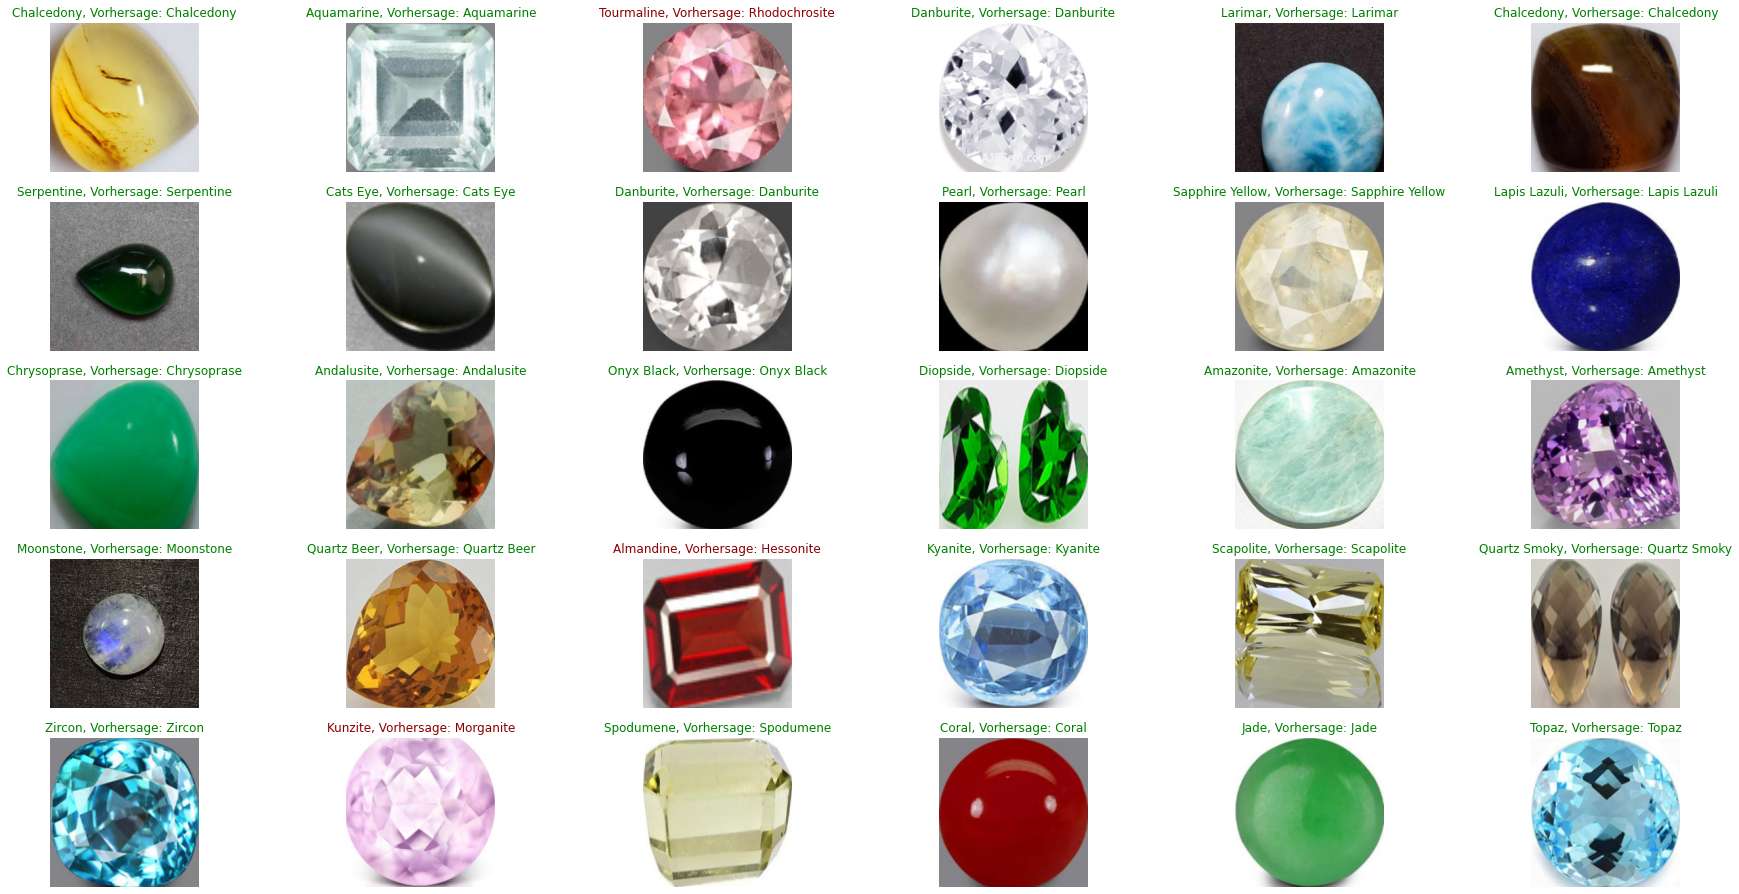

In [29]:
f,ax = plt.subplots(5,6)
f.subplots_adjust(0,0,4,3)
for i in range(5):
    for j in range(6):
        rnd = randint(0,len(cropages))
        pred_image = np.array([cropages[rnd]])
        pred_class = model.predict_classes(pred_image)[0]
        ax[i][j].imshow(cropages[rnd])
        ax[i][j].imshow(pred_image[0])
        if(names[pred_class] != names[labels[rnd]]):
            t = '{}, Vorhersage: {}'.format(names[labels[rnd]],names[pred_class])
            ax[i,j].set_title(t, fontdict={'color': 'darkred'})
        else:
            t = '{}, Vorhersage: {}'.format(names[labels[rnd]],names[pred_class]) 
            ax[i,j].set_title(t, fontdict={'color': 'green'})
        ax[i,j].axis('off')

## 5. Fazit und ethische Aspekte

### Fazit
#### Die Feststellung, dass bearbeitete Edelsteine sich je nachdem nur durch Schliff und Farbe unterscheiden, bildete Grundlage für unser Projekt. Ziel unserer Arbeit war es, die für Laien bereits schwierige Klassifizierung von Edelsteinen durch eine KI zu ersetzen oder zumindest weitestgehend zu erleichtern.

#### Unser erklärtes Ziel, dass der Algorithmus mindestens eine Genauigkeit von 50 % erreichen sollte, haben wir übertroffen: Bei der Anwendung des trainierten Systems auf den Testdatensatzes erreichen wir eine für unsere Ansprüche hohe Trefferquote von 74.31 %.

#### Im speziellen möchten wir folgende Schlüsse hervorheben:
#### - Das Modell tendiert, wenn auch nur leicht, zu Overfitting. Die Trainingsgenauigkeit liegt nicht wesentlich über der Validierungsgenauigkeit. Durch Regularisierungsmechanismen wie Mixed Pooling sowie dem Einsatz einer Dropout Rate wurde das Problem des Overfittings angegangen und so fällt sie vergleichsweise niedrig aus.
#### - Durch Analyse der Confusion Matrix erkannten wir, dass die KI sich mit den ähnlichen Erkennungsschwierigkeiten wie jene des nichtkundigen Menschen herumschlägt: Edelsteine, die sich farblich und / oder vom Schliff nur leicht voneinander unterscheiden, sind auch für den Algorithmus schwierig zu klassifizieren. Das Modell hat im Vergleich zum Laien jedoch in kürzester Zeit einen grossen Datensatz gesichtet und trainiert. Die Treffsicherheit ist verhältnismässig hoch.



### Ethische Aspekte
#### Beim Webscraping kann man sich die Frage stellen, wie es sich ethisch um die Datenbeschaffung verhält. 
#### Bei der Sammlung von Onlinedaten ist besonders zu beachten, dass oft eine Fülle von Informationen ohne das Wissen der publizierenden Personen oder deren Zustimmung erhoben werden können. 

#### Da es sich in unserem Fall jedoch nicht um personenbezogene oder persönlich sensible Daten handelt und Webscraping weder explizit verboten (aber auch nicht erlaubt) ist, sehen wir uns keinen moralischen Bedenken ausgesetzt. 

#### Hinzu kommt, dass die gescrapten Daten lediglich im Rahmen unseres Projektes und wissenschaftlich verwendet und damit nicht veröffentlicht werden. Damit sehen wir auch von der Problematik eventuell urheberrechtlich geschützter Bilder ab. 